# 🧬 Stanford Ribonanza RNA Folding 2: Baseline Solution
이 노트북은 RNA 서열 데이터를 활용하여 3D 구조(좌표)를 예측하는 딥러닝 모델의 파이프라인을 다룹니다.

---

## 1. Import
필요한 라이브러리를 로드합니다.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. 데이터 전처리 (Data Preprocessing)
서열 데이터를 정수 인코딩하고, 라벨(3D 좌표)과 매칭하여 학습용 데이터셋을 생성합니다.

In [2]:
# 1. 데이터 로드
train_seq = pd.read_csv('train_sequences.csv')
train_labels = pd.read_csv('train_labels.csv')

print(f"Sequence data shape: {train_seq.shape}")
print(f"Label data shape: {train_labels.shape}")

C:\Users\tkdwl\AppData\Local\Temp\ipykernel_25088\941589194.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train_labels = pd.read_csv('train_labels.csv')


Sequence data shape: (5716, 8)
Label data shape: (7794971, 8)


In [3]:
# 2. 서열 토큰화 (A, C, G, U -> 1, 2, 3, 4)
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}
train_seq['tokenized'] = train_seq['sequence'].apply(lambda x: [mapping.get(base, 0) for base in x])

In [4]:
# 3. 라벨 전처리: ID -> target_id 분리 (맨 뒤 _resid 만 떼어냄)
train_labels['target_id'] = (
    train_labels['ID'].astype(str).str.rsplit('_', n=1).str[0]
)

# resid가 있으면 정렬해서 "좌표 순서 = 서열 순서" 맞추기
if 'resid' in train_labels.columns:
    train_labels = train_labels.sort_values(['target_id', 'resid'])
else:
    train_labels = train_labels.sort_values(['target_id'])

# target_id 별로 (L,3) 좌표 리스트 만들기
coords_df = (
    train_labels.groupby('target_id')[['x_1', 'y_1', 'z_1']]
    .apply(lambda x: x.to_numpy().tolist())
    .reset_index(name='coordinates')
)

# merge 키 정리(공백/타입 이슈 방지)
train_seq['target_id'] = train_seq['target_id'].astype(str).str.strip()
coords_df['target_id'] = coords_df['target_id'].astype(str).str.strip()

# 서열 + 좌표 병합 (inner가 기본)
train_df = train_seq.merge(coords_df, on='target_id', how='inner')

print("train_seq:", train_seq.shape)
print("coords_df:", coords_df.shape)
print("train_df:", train_df.shape)

assert len(train_df) > 0, "merge 결과가 비었습니다: target_id 키 매칭이 안 됩니다."


train_seq: (5716, 9)
coords_df: (5716, 2)
train_df: (5716, 10)


In [5]:
common = set(train_seq['target_id']).intersection(set(coords_df['target_id']))
print("공통 target_id 개수:", len(common))
print("예시 target_id (seq):", train_seq['target_id'].head().tolist())
print("예시 target_id (coords):", coords_df['target_id'].head().tolist())


공통 target_id 개수: 5716
예시 target_id (seq): ['4TNA', '6TNA', '1TRA', '1TN2', '1TN1']
예시 target_id (coords): ['157D', '165D', '17RA', '1A1T', '1A34']


In [6]:
print(train_df.shape)

(5716, 10)


In [14]:
train_df['seq_len'] = train_df['sequence'].str.len()
train_df['coord_len'] = train_df['coordinates'].apply(len)
mismatch = train_df['seq_len'] != train_df['coord_len']

print("길이 불일치 샘플 수:", mismatch.sum())
print(train_df.loc[mismatch, ['target_id','seq_len','coord_len']].head())


길이 불일치 샘플 수: 0
Empty DataFrame
Columns: [target_id, seq_len, coord_len]
Index: []


In [13]:
import numpy as np

def coord_has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

bad = train_df['coordinates'].apply(coord_has_nan_inf)
print("NaN/Inf 좌표 샘플 수:", bad.sum())
print("예시 target_id:", train_df.loc[bad, 'target_id'].head().tolist())


NaN/Inf 좌표 샘플 수: 3045
예시 target_id: ['2TRA', '3TRA', '1SER', '1URN', '1QRS']


In [7]:
# ==========================================
# 1. Custom Loss: Kabsch RMSD (Rotation Invariant)
# ==========================================
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

def kabsch_rotation(P, Q, mask=None):
    # P, Q: (batch, N, 3)
    # mask: (batch, N) - 1 for valid, 0 for pad
    
    if mask is None:
        mask = torch.ones(P.shape[0], P.shape[1], device=P.device)
    
    # Expand mask for coordinates
    mask_exp = mask.unsqueeze(-1) # (batch, N, 1)
    
    # Compute centroids of VALID points only
    # Sum over N, divide by sum of mask
    mask_sum = mask_exp.sum(dim=1, keepdim=True) + 1e-8 # (batch, 1, 1)
    
    P_mean = (P * mask_exp).sum(dim=1, keepdim=True) / mask_sum
    Q_mean = (Q * mask_exp).sum(dim=1, keepdim=True) / mask_sum
    
    P_c = (P - P_mean) * mask_exp
    Q_c = (Q - Q_mean) * mask_exp

    # Covariance matrix H
    # (batch, 3, N) @ (batch, N, 3) -> (batch, 3, 3)
    H = torch.matmul(P_c.transpose(1, 2), Q_c) 

    # SVD
    try:
        U, S, V = torch.linalg.svd(H)
    except:
        U, S, V = torch.svd(H)

    # Correct for reflection
    d = torch.det(torch.matmul(V, U.transpose(1, 2))) # (batch,)
    E = torch.eye(3, device=P.device).unsqueeze(0).repeat(P.shape[0], 1, 1)
    E[:, 2, 2] = d

    # Rotation matrix R
    R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2)) # (batch, 3, 3)

    # Rotate P to align with Q
    P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean
    
    # Return aligned P, masked
    return P_aligned * mask_exp

class KabschRMSDLoss(nn.Module):
    def __init__(self):
        super(KabschRMSDLoss, self).__init__()

    def forward(self, preds, target, mask):
        # preds: (batch, num_preds, seq_len, 3)
        # target: (batch, seq_len, 3)
        # mask: (batch, seq_len)
        
        batch_size, num_preds, seq_len, _ = preds.shape
        
        losses = []
        for k in range(num_preds):
            pred_k = preds[:, k, :, :]
            
            # Align only using valid points
            pred_aligned = kabsch_rotation(pred_k, target, mask)
            
            # Calculate MSE only on valid points
            diff_sq = (pred_aligned - target) ** 2
            
            # Sum over seq_len and 3 coordinates
            sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2)) # (batch,)
            
            # Divide by number of valid points * 3
            n_valid = mask.sum(dim=1) * 3 + 1e-8
            
            mse = sum_sq / n_valid
            rmsd = torch.sqrt(mse + 1e-8)
            losses.append(rmsd)
        
        losses = torch.stack(losses, dim=1) # (batch, num_preds)
        min_loss, _ = torch.min(losses, dim=1)
        return torch.mean(min_loss)

# ==========================================
# 2. Dataset Definition
# ==========================================
class RNADataset(Dataset):
    def __init__(self, sequences, coordinates, max_len=200):
        self.sequences = sequences
        self.coordinates = coordinates
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        coords = self.coordinates[idx]
        
        # Padding Sequence
        curr_seq_len = len(seq)
        
        # Create Mask (1 for valid, 0 for pad)
        actual_len = min(curr_seq_len, self.max_len)
        mask = np.zeros(self.max_len, dtype=np.float32)
        mask[:actual_len] = 1.0
        
        if curr_seq_len < self.max_len:
            seq_padded = seq + [0] * (self.max_len - curr_seq_len)
        else:
            seq_padded = seq[:self.max_len]
            
        # Padding Coordinates
        coords = np.array(coords, dtype=np.float32)
        curr_coord_len = coords.shape[0]
        
        if curr_coord_len < self.max_len:
            pad_len = self.max_len - curr_coord_len
            coords_padded = np.pad(coords, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)
        else:
            coords_padded = coords[:self.max_len]
        
        return torch.tensor(seq_padded, dtype=torch.long), torch.tensor(coords_padded, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [8]:
# 데이터 분할
train_idx, val_idx = train_test_split(range(len(train_df)), test_size=0.1, random_state=42)

train_dataset = RNADataset(train_df.iloc[train_idx]['tokenized'].values, train_df.iloc[train_idx]['coordinates'].values)
val_dataset = RNADataset(train_df.iloc[val_idx]['tokenized'].values, train_df.iloc[val_idx]['coordinates'].values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 3. 모델 선정 (Model Selection)
RNA의 2차 및 3차 구조는 염기 간의 원거리 상호작용(Long-range interaction)에 의해 결정되므로, **Transformer** 아키텍처가 매우 효과적입니다.

### 선정 모델: RNA Transformer Encoder
- **Self-Attention:** 서열 내 모든 위치 간의 관계를 학습합니다.
- **Output Head:** 각 토큰 위치에서 (x, y, z) 좌표를 예측하도록 구성합니다.

In [9]:
class RNATransformer(nn.Module):
    def __init__(self, n_tokens=5, d_model=128, nhead=8, num_layers=4, dropout=0.1, num_preds=5):
        super(RNATransformer, self).__init__()
        self.embedding = nn.Embedding(n_tokens, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))
        
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_model*4, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # HEAD MODIFICATION: Output 5 separate structures
        self.num_preds = num_preds
        # Project d_model -> 3 * num_preds (x, y, z for each of 5 predictions)
        self.fc_coords = nn.Linear(d_model, 3 * num_preds) 
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        
        x = self.embedding(x)
        x = x + self.pos_encoder[:, :seq_len, :]
        x = self.transformer_encoder(x)
        
        # Predict coordinates
        out = self.fc_coords(x) # (batch, seq_len, 3 * num_preds)
        
        # Reshape to (batch, num_preds, seq_len, 3)
        out = out.view(batch_size, seq_len, self.num_preds, 3)
        out = out.permute(0, 2, 1, 3)
        
        return out

model = RNATransformer(num_preds=5).to(device)
print("Model Initialized with Best-of-5 Output Strategy.")


Model Initialized with Best-of-5 Output Strategy.


## 4. 모델 학습 (Model Training)
MAE Loss를 최소화하도록 모델을 최적화합니다.

In [10]:
# Initialize Custom Loss
criterion = KabschRMSDLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 5
print(f"Starting Training for {epochs} epochs...")

for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for seq, target, mask in pbar:
        seq, target, mask = seq.to(device), target.to(device), mask.to(device)
        
        optimizer.zero_grad()
        preds = model(seq) # (batch, 5, seq_len, 3)
        
        loss = criterion(preds, target, mask)
        
        if torch.isnan(loss):
            print("Warning: Loss is NaN")
            continue
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping
        optimizer.step()
        
        train_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = train_loss/len(train_loader)
    print(f"Epoch {epoch+1} Average Train Loss: {avg_loss:.4f}")


Starting Training for 5 epochs...


Epoch 1/5:   2%|▏         | 3/161 [00:00<00:18,  8.72it/s]

Epoch 1/5:   4%|▍         | 7/161 [00:00<00:12, 12.32it/s]

Epoch 1/5:   7%|▋         | 11/161 [00:00<00:10, 14.67it/s]

Epoch 1/5:   9%|▉         | 15/161 [00:01<00:09, 15.90it/s]

Epoch 1/5:  11%|█         | 17/161 [00:01<00:09, 15.30it/s]

Epoch 1/5:  13%|█▎        | 21/161 [00:01<00:10, 13.16it/s]

Epoch 1/5:  16%|█▌        | 25/161 [00:01<00:09, 14.48it/s]

Epoch 1/5:  18%|█▊        | 29/161 [00:02<00:08, 15.82it/s]

Epoch 1/5:  20%|██        | 33/161 [00:02<00:08, 15.72it/s]

Epoch 1/5:  22%|██▏       | 35/161 [00:02<00:07, 16.18it/s]

Epoch 1/5:  24%|██▍       | 39/161 [00:02<00:07, 15.28it/s]

Epoch 1/5:  27%|██▋       | 43/161 [00:03<00:07, 15.40it/s]

Epoch 1/5:  29%|██▉       | 47/161 [00:03<00:07, 15.28it/s]

Epoch 1/5:  32%|███▏      | 51/161 [00:03<00:06, 15.98it/s]

Epoch 1/5:  34%|███▍      | 55/161 [00:03<00:06, 16.45it/s]

Epoch 1/5:  37%|███▋      | 59/161 [00:04<00:06, 15.68it/s]

Epoch 1/5:  39%|███▉      | 63/161 [00:04<00:06, 15.99it/s]

Epoch 1/5:  42%|████▏     | 67/161 [00:04<00:05, 16.04it/s]

Epoch 1/5:  44%|████▍     | 71/161 [00:04<00:05, 16.64it/s]

Epoch 1/5:  47%|████▋     | 75/161 [00:04<00:05, 15.76it/s]

Epoch 1/5:  48%|████▊     | 77/161 [00:05<00:05, 16.12it/s]

Epoch 1/5:  50%|█████     | 81/161 [00:05<00:05, 15.34it/s]

Epoch 1/5:  53%|█████▎    | 85/161 [00:05<00:04, 15.52it/s]

Epoch 1/5:  55%|█████▌    | 89/161 [00:05<00:04, 15.77it/s]

Epoch 1/5:  58%|█████▊    | 93/161 [00:06<00:04, 15.77it/s]

Epoch 1/5:  60%|██████    | 97/161 [00:06<00:04, 15.34it/s]

Epoch 1/5:  63%|██████▎   | 101/161 [00:06<00:03, 16.15it/s]

Epoch 1/5:  65%|██████▌   | 105/161 [00:06<00:03, 15.06it/s]

Epoch 1/5:  66%|██████▋   | 107/161 [00:07<00:03, 14.84it/s]

Epoch 1/5:  69%|██████▉   | 111/161 [00:07<00:03, 14.85it/s]

Epoch 1/5:  71%|███████▏  | 115/161 [00:07<00:03, 14.59it/s]

Epoch 1/5:  74%|███████▍  | 119/161 [00:07<00:02, 14.95it/s]

Epoch 1/5:  76%|███████▋  | 123/161 [00:08<00:02, 15.08it/s]

Epoch 1/5:  79%|███████▉  | 127/161 [00:08<00:02, 15.31it/s]

Epoch 1/5:  81%|████████▏ | 131/161 [00:08<00:01, 15.41it/s]

Epoch 1/5:  84%|████████▍ | 135/161 [00:08<00:01, 15.09it/s]

Epoch 1/5:  86%|████████▋ | 139/161 [00:09<00:01, 15.54it/s]

Epoch 1/5:  89%|████████▉ | 143/161 [00:09<00:01, 16.08it/s]

Epoch 1/5:  91%|█████████▏| 147/161 [00:09<00:00, 15.45it/s]

Epoch 1/5:  94%|█████████▍| 151/161 [00:09<00:00, 15.37it/s]

Epoch 1/5:  95%|█████████▌| 153/161 [00:10<00:00, 15.23it/s]

Epoch 1/5:  98%|█████████▊| 157/161 [00:10<00:00, 14.94it/s]

Epoch 1/5: 100%|██████████| 161/161 [00:10<00:00, 15.16it/s]

Epoch 1 Average Train Loss: 0.0000



Epoch 2/5:   2%|▏         | 4/161 [00:00<00:10, 15.13it/s]

Epoch 2/5:   5%|▍         | 8/161 [00:00<00:10, 15.09it/s]

Epoch 2/5:   7%|▋         | 12/161 [00:00<00:09, 15.28it/s]

Epoch 2/5:  10%|▉         | 16/161 [00:01<00:09, 14.63it/s]

Epoch 2/5:  12%|█▏        | 20/161 [00:01<00:09, 15.10it/s]

Epoch 2/5:  15%|█▍        | 24/161 [00:01<00:08, 16.04it/s]

Epoch 2/5:  17%|█▋        | 28/161 [00:01<00:08, 15.89it/s]

Epoch 2/5:  20%|█▉        | 32/161 [00:02<00:07, 16.35it/s]

Epoch 2/5:  22%|██▏       | 36/161 [00:02<00:07, 15.76it/s]

Epoch 2/5:  24%|██▎       | 38/161 [00:02<00:08, 15.35it/s]

Epoch 2/5:  26%|██▌       | 42/161 [00:02<00:07, 15.30it/s]

Epoch 2/5:  29%|██▊       | 46/161 [00:02<00:07, 15.74it/s]

Epoch 2/5:  31%|███       | 50/161 [00:03<00:07, 15.43it/s]

Epoch 2/5:  34%|███▎      | 54/161 [00:03<00:07, 14.87it/s]

Epoch 2/5:  36%|███▌      | 58/161 [00:03<00:06, 15.60it/s]

Epoch 2/5:  39%|███▊      | 62/161 [00:04<00:06, 15.40it/s]

Epoch 2/5:  40%|███▉      | 64/161 [00:04<00:06, 14.28it/s]

Epoch 2/5:  42%|████▏     | 68/161 [00:04<00:06, 14.92it/s]

Epoch 2/5:  45%|████▍     | 72/161 [00:04<00:06, 14.39it/s]

Epoch 2/5:  47%|████▋     | 76/161 [00:04<00:05, 14.82it/s]

Epoch 2/5:  50%|████▉     | 80/161 [00:05<00:05, 14.49it/s]

Epoch 2/5:  51%|█████     | 82/161 [00:05<00:05, 14.85it/s]

Epoch 2/5:  53%|█████▎    | 86/161 [00:05<00:05, 14.27it/s]

Epoch 2/5:  56%|█████▌    | 90/161 [00:05<00:04, 14.94it/s]

Epoch 2/5:  57%|█████▋    | 92/161 [00:06<00:04, 14.38it/s]

Epoch 2/5:  60%|█████▉    | 96/161 [00:06<00:04, 14.02it/s]

Epoch 2/5:  61%|██████    | 98/161 [00:06<00:04, 13.91it/s]

Epoch 2/5:  63%|██████▎   | 102/161 [00:06<00:04, 13.87it/s]

Epoch 2/5:  66%|██████▌   | 106/161 [00:07<00:03, 14.26it/s]

Epoch 2/5:  68%|██████▊   | 110/161 [00:07<00:03, 14.72it/s]

Epoch 2/5:  71%|███████   | 114/161 [00:07<00:03, 14.83it/s]

Epoch 2/5:  73%|███████▎  | 118/161 [00:07<00:02, 15.13it/s]

Epoch 2/5:  76%|███████▌  | 122/161 [00:08<00:02, 15.02it/s]

Epoch 2/5:  78%|███████▊  | 126/161 [00:08<00:02, 15.59it/s]

Epoch 2/5:  80%|███████▉  | 128/161 [00:08<00:02, 14.99it/s]

Epoch 2/5:  82%|████████▏ | 132/161 [00:08<00:01, 14.58it/s]

Epoch 2/5:  83%|████████▎ | 134/161 [00:08<00:01, 14.43it/s]

Epoch 2/5:  86%|████████▌ | 138/161 [00:09<00:01, 13.96it/s]

Epoch 2/5:  87%|████████▋ | 140/161 [00:09<00:01, 13.96it/s]

Epoch 2/5:  89%|████████▉ | 144/161 [00:09<00:01, 13.92it/s]

Epoch 2/5:  92%|█████████▏| 148/161 [00:09<00:00, 14.05it/s]

Epoch 2/5:  93%|█████████▎| 150/161 [00:10<00:00, 14.13it/s]

Epoch 2/5:  96%|█████████▌| 154/161 [00:10<00:00, 14.72it/s]

Epoch 2/5:  98%|█████████▊| 158/161 [00:10<00:00, 15.22it/s]

Epoch 2/5: 100%|██████████| 161/161 [00:10<00:00, 14.90it/s]


Epoch 2 Average Train Loss: 0.0000


Epoch 3/5:   1%|          | 2/161 [00:00<00:11, 13.92it/s]

Epoch 3/5:   2%|▏         | 4/161 [00:00<00:12, 12.88it/s]

Epoch 3/5:   4%|▎         | 6/161 [00:00<00:12, 12.83it/s]

Epoch 3/5:   5%|▍         | 8/161 [00:00<00:11, 13.04it/s]

Epoch 3/5:   7%|▋         | 12/161 [00:00<00:10, 14.37it/s]

Epoch 3/5:  10%|▉         | 16/161 [00:01<00:09, 15.46it/s]

Epoch 3/5:  12%|█▏        | 20/161 [00:01<00:09, 14.93it/s]

Epoch 3/5:  15%|█▍        | 24/161 [00:01<00:09, 14.80it/s]

Epoch 3/5:  17%|█▋        | 28/161 [00:01<00:09, 14.63it/s]

Epoch 3/5:  20%|█▉        | 32/161 [00:02<00:09, 14.03it/s]

Epoch 3/5:  21%|██        | 34/161 [00:02<00:09, 13.94it/s]

Epoch 3/5:  24%|██▎       | 38/161 [00:02<00:08, 14.59it/s]

Epoch 3/5:  26%|██▌       | 42/161 [00:02<00:08, 14.57it/s]

Epoch 3/5:  29%|██▊       | 46/161 [00:03<00:07, 14.69it/s]

Epoch 3/5:  31%|███       | 50/161 [00:03<00:07, 15.08it/s]

Epoch 3/5:  34%|███▎      | 54/161 [00:03<00:07, 15.07it/s]

Epoch 3/5:  36%|███▌      | 58/161 [00:03<00:06, 15.69it/s]

Epoch 3/5:  37%|███▋      | 60/161 [00:04<00:06, 14.99it/s]

Epoch 3/5:  40%|███▉      | 64/161 [00:04<00:06, 14.75it/s]

Epoch 3/5:  42%|████▏     | 68/161 [00:04<00:06, 14.94it/s]

Epoch 3/5:  45%|████▍     | 72/161 [00:04<00:06, 14.23it/s]

Epoch 3/5:  46%|████▌     | 74/161 [00:05<00:06, 13.77it/s]

Epoch 3/5:  48%|████▊     | 78/161 [00:05<00:05, 14.86it/s]

Epoch 3/5:  51%|█████     | 82/161 [00:05<00:05, 14.60it/s]

Epoch 3/5:  53%|█████▎    | 86/161 [00:05<00:04, 15.32it/s]

Epoch 3/5:  55%|█████▍    | 88/161 [00:06<00:05, 14.47it/s]

Epoch 3/5:  57%|█████▋    | 92/161 [00:06<00:04, 14.12it/s]

Epoch 3/5:  60%|█████▉    | 96/161 [00:06<00:04, 14.12it/s]

Epoch 3/5:  61%|██████    | 98/161 [00:06<00:04, 14.00it/s]

Epoch 3/5:  63%|██████▎   | 102/161 [00:07<00:04, 13.57it/s]

Epoch 3/5:  65%|██████▍   | 104/161 [00:07<00:04, 13.54it/s]

Epoch 3/5:  67%|██████▋   | 108/161 [00:07<00:03, 13.79it/s]

Epoch 3/5:  70%|██████▉   | 112/161 [00:07<00:03, 14.44it/s]

Epoch 3/5:  71%|███████   | 114/161 [00:07<00:03, 14.15it/s]

Epoch 3/5:  73%|███████▎  | 118/161 [00:08<00:03, 12.98it/s]

Epoch 3/5:  75%|███████▍  | 120/161 [00:08<00:03, 12.69it/s]

Epoch 3/5:  77%|███████▋  | 124/161 [00:08<00:02, 12.85it/s]

Epoch 3/5:  78%|███████▊  | 126/161 [00:08<00:02, 12.61it/s]

Epoch 3/5:  81%|████████  | 130/161 [00:09<00:02, 12.59it/s]

Epoch 3/5:  82%|████████▏ | 132/161 [00:09<00:02, 12.29it/s]

Epoch 3/5:  84%|████████▍ | 136/161 [00:09<00:01, 12.82it/s]

Epoch 3/5:  86%|████████▌ | 138/161 [00:09<00:01, 12.49it/s]

Epoch 3/5:  88%|████████▊ | 142/161 [00:10<00:01, 12.78it/s]

Epoch 3/5:  89%|████████▉ | 144/161 [00:10<00:01, 13.05it/s]

Epoch 3/5:  92%|█████████▏| 148/161 [00:10<00:00, 13.11it/s]

Epoch 3/5:  93%|█████████▎| 150/161 [00:10<00:00, 12.97it/s]

Epoch 3/5:  96%|█████████▌| 154/161 [00:11<00:00, 13.73it/s]

Epoch 3/5:  98%|█████████▊| 158/161 [00:11<00:00, 13.78it/s]

Epoch 3/5: 100%|██████████| 161/161 [00:11<00:00, 13.99it/s]


Epoch 3 Average Train Loss: 0.0000


Epoch 4/5:   2%|▏         | 4/161 [00:00<00:10, 14.48it/s]

Epoch 4/5:   4%|▎         | 6/161 [00:00<00:11, 13.55it/s]

Epoch 4/5:   6%|▌         | 10/161 [00:00<00:11, 13.04it/s]

Epoch 4/5:   7%|▋         | 12/161 [00:00<00:11, 12.75it/s]

Epoch 4/5:  10%|▉         | 16/161 [00:01<00:11, 12.86it/s]

Epoch 4/5:  11%|█         | 18/161 [00:01<00:11, 12.91it/s]

Epoch 4/5:  14%|█▎        | 22/161 [00:01<00:10, 13.42it/s]

Epoch 4/5:  16%|█▌        | 26/161 [00:01<00:10, 13.41it/s]

Epoch 4/5:  17%|█▋        | 28/161 [00:02<00:09, 13.66it/s]

Epoch 4/5:  20%|█▉        | 32/161 [00:02<00:09, 13.27it/s]

Epoch 4/5:  21%|██        | 34/161 [00:02<00:09, 13.09it/s]

Epoch 4/5:  24%|██▎       | 38/161 [00:02<00:09, 13.17it/s]

Epoch 4/5:  26%|██▌       | 42/161 [00:03<00:08, 13.61it/s]

Epoch 4/5:  27%|██▋       | 44/161 [00:03<00:08, 13.43it/s]

Epoch 4/5:  30%|██▉       | 48/161 [00:03<00:08, 13.23it/s]

Epoch 4/5:  32%|███▏      | 52/161 [00:03<00:07, 13.88it/s]

Epoch 4/5:  34%|███▎      | 54/161 [00:04<00:07, 13.67it/s]

Epoch 4/5:  36%|███▌      | 58/161 [00:04<00:07, 14.13it/s]

Epoch 4/5:  39%|███▊      | 62/161 [00:04<00:07, 13.51it/s]

Epoch 4/5:  40%|███▉      | 64/161 [00:04<00:07, 13.79it/s]

Epoch 4/5:  42%|████▏     | 68/161 [00:05<00:06, 14.20it/s]

Epoch 4/5:  45%|████▍     | 72/161 [00:05<00:06, 14.33it/s]

Epoch 4/5:  46%|████▌     | 74/161 [00:05<00:06, 13.80it/s]

Epoch 4/5:  48%|████▊     | 78/161 [00:05<00:05, 13.99it/s]

Epoch 4/5:  51%|█████     | 82/161 [00:06<00:05, 13.90it/s]

Epoch 4/5:  52%|█████▏    | 84/161 [00:06<00:05, 14.04it/s]

Epoch 4/5:  55%|█████▍    | 88/161 [00:06<00:05, 13.79it/s]

Epoch 4/5:  56%|█████▌    | 90/161 [00:06<00:05, 13.37it/s]

Epoch 4/5:  58%|█████▊    | 94/161 [00:06<00:04, 13.59it/s]

Epoch 4/5:  60%|█████▉    | 96/161 [00:07<00:04, 13.32it/s]

Epoch 4/5:  62%|██████▏   | 100/161 [00:07<00:04, 12.85it/s]

Epoch 4/5:  63%|██████▎   | 102/161 [00:07<00:04, 12.78it/s]

Epoch 4/5:  66%|██████▌   | 106/161 [00:07<00:04, 12.30it/s]

Epoch 4/5:  67%|██████▋   | 108/161 [00:08<00:04, 11.82it/s]

Epoch 4/5:  70%|██████▉   | 112/161 [00:08<00:04, 11.96it/s]

Epoch 4/5:  71%|███████   | 114/161 [00:08<00:03, 12.24it/s]

Epoch 4/5:  73%|███████▎  | 118/161 [00:08<00:03, 12.46it/s]

Epoch 4/5:  75%|███████▍  | 120/161 [00:09<00:03, 12.12it/s]

Epoch 4/5:  77%|███████▋  | 124/161 [00:09<00:03, 11.59it/s]

Epoch 4/5:  78%|███████▊  | 126/161 [00:09<00:03, 11.20it/s]

Epoch 4/5:  81%|████████  | 130/161 [00:09<00:02, 11.06it/s]

Epoch 4/5:  82%|████████▏ | 132/161 [00:10<00:02, 11.09it/s]

Epoch 4/5:  84%|████████▍ | 136/161 [00:10<00:02, 11.12it/s]

Epoch 4/5:  86%|████████▌ | 138/161 [00:10<00:02, 11.38it/s]

Epoch 4/5:  88%|████████▊ | 142/161 [00:11<00:01, 11.42it/s]

Epoch 4/5:  89%|████████▉ | 144/161 [00:11<00:01, 11.68it/s]

Epoch 4/5:  92%|█████████▏| 148/161 [00:11<00:01, 11.55it/s]

Epoch 4/5:  93%|█████████▎| 150/161 [00:11<00:00, 11.88it/s]

Epoch 4/5:  96%|█████████▌| 154/161 [00:12<00:00, 11.78it/s]

Epoch 4/5:  97%|█████████▋| 156/161 [00:12<00:00, 12.08it/s]

Epoch 4/5:  99%|█████████▉| 160/161 [00:12<00:00, 12.42it/s]

Epoch 4/5: 100%|██████████| 161/161 [00:12<00:00, 12.79it/s]


Epoch 4 Average Train Loss: 0.0000


Epoch 5/5:   1%|          | 2/161 [00:00<00:15, 10.55it/s]

Epoch 5/5:   2%|▏         | 4/161 [00:00<00:14, 10.81it/s]

Epoch 5/5:   4%|▎         | 6/161 [00:00<00:13, 11.66it/s]

Epoch 5/5:   5%|▍         | 8/161 [00:00<00:13, 11.67it/s]

Epoch 5/5:   6%|▌         | 10/161 [00:00<00:13, 11.21it/s]

Epoch 5/5:   7%|▋         | 12/161 [00:01<00:12, 12.21it/s]

Epoch 5/5:   9%|▊         | 14/161 [00:01<00:11, 12.33it/s]

Epoch 5/5:  10%|▉         | 16/161 [00:01<00:12, 11.86it/s]

Epoch 5/5:  11%|█         | 18/161 [00:01<00:12, 11.67it/s]

Epoch 5/5:  12%|█▏        | 20/161 [00:01<00:11, 12.10it/s]

Epoch 5/5:  14%|█▎        | 22/161 [00:01<00:12, 11.58it/s]

Epoch 5/5:  15%|█▍        | 24/161 [00:02<00:12, 11.20it/s]

Epoch 5/5:  16%|█▌        | 26/161 [00:02<00:11, 11.28it/s]

Epoch 5/5:  17%|█▋        | 28/161 [00:02<00:11, 11.19it/s]

Epoch 5/5:  19%|█▊        | 30/161 [00:02<00:11, 11.05it/s]

Epoch 5/5:  20%|█▉        | 32/161 [00:02<00:11, 10.82it/s]

Epoch 5/5:  21%|██        | 34/161 [00:02<00:10, 11.60it/s]

Epoch 5/5:  22%|██▏       | 36/161 [00:03<00:10, 11.38it/s]

Epoch 5/5:  24%|██▎       | 38/161 [00:03<00:10, 11.66it/s]

Epoch 5/5:  25%|██▍       | 40/161 [00:03<00:10, 11.27it/s]

Epoch 5/5:  26%|██▌       | 42/161 [00:03<00:10, 11.38it/s]

Epoch 5/5:  27%|██▋       | 44/161 [00:03<00:10, 11.39it/s]

Epoch 5/5:  29%|██▊       | 46/161 [00:03<00:09, 11.84it/s]

Epoch 5/5:  30%|██▉       | 48/161 [00:04<00:09, 11.50it/s]

Epoch 5/5:  31%|███       | 50/161 [00:04<00:09, 11.38it/s]

Epoch 5/5:  32%|███▏      | 52/161 [00:04<00:09, 11.09it/s]

Epoch 5/5:  34%|███▎      | 54/161 [00:04<00:09, 11.21it/s]

Epoch 5/5:  35%|███▍      | 56/161 [00:04<00:09, 11.37it/s]

Epoch 5/5:  36%|███▌      | 58/161 [00:05<00:09, 10.97it/s]

Epoch 5/5:  37%|███▋      | 60/161 [00:05<00:08, 11.46it/s]

Epoch 5/5:  39%|███▊      | 62/161 [00:05<00:08, 11.68it/s]

Epoch 5/5:  40%|███▉      | 64/161 [00:05<00:08, 11.98it/s]

Epoch 5/5:  41%|████      | 66/161 [00:05<00:08, 11.57it/s]

Epoch 5/5:  42%|████▏     | 68/161 [00:05<00:08, 11.45it/s]

Epoch 5/5:  43%|████▎     | 70/161 [00:06<00:07, 11.69it/s]

Epoch 5/5:  45%|████▍     | 72/161 [00:06<00:07, 11.55it/s]

Epoch 5/5:  46%|████▌     | 74/161 [00:06<00:07, 11.93it/s]

Epoch 5/5:  47%|████▋     | 76/161 [00:06<00:07, 12.03it/s]

Epoch 5/5:  48%|████▊     | 78/161 [00:06<00:07, 11.69it/s]

Epoch 5/5:  50%|████▉     | 80/161 [00:06<00:07, 11.49it/s]

Epoch 5/5:  51%|█████     | 82/161 [00:07<00:06, 11.88it/s]

Epoch 5/5:  52%|█████▏    | 84/161 [00:07<00:06, 11.65it/s]

Epoch 5/5:  53%|█████▎    | 86/161 [00:07<00:06, 11.57it/s]

Epoch 5/5:  55%|█████▍    | 88/161 [00:08<00:20,  3.61it/s]

Epoch 5/5:  55%|█████▌    | 89/161 [00:09<00:29,  2.47it/s]

Epoch 5/5:  56%|█████▌    | 90/161 [00:10<00:34,  2.07it/s]

Epoch 5/5:  57%|█████▋    | 91/161 [00:11<00:42,  1.66it/s]

Epoch 5/5:  57%|█████▋    | 92/161 [00:12<00:48,  1.42it/s]

Epoch 5/5:  58%|█████▊    | 93/161 [00:13<00:53,  1.28it/s]

Epoch 5/5:  58%|█████▊    | 94/161 [00:14<00:56,  1.19it/s]

Epoch 5/5:  59%|█████▉    | 95/161 [00:15<00:54,  1.20it/s]

Epoch 5/5:  60%|█████▉    | 96/161 [00:16<00:52,  1.23it/s]

Epoch 5/5:  60%|██████    | 97/161 [00:17<00:55,  1.14it/s]

Epoch 5/5:  61%|██████    | 98/161 [00:18<01:00,  1.05it/s]

Epoch 5/5:  61%|██████▏   | 99/161 [00:19<00:59,  1.04it/s]

Epoch 5/5:  62%|██████▏   | 100/161 [00:20<00:59,  1.03it/s]

Epoch 5/5:  63%|██████▎   | 101/161 [00:21<00:58,  1.02it/s]

Epoch 5/5:  63%|██████▎   | 102/161 [00:22<00:59,  1.00s/it]

Epoch 5/5:  64%|██████▍   | 103/161 [00:23<00:53,  1.08it/s]

Epoch 5/5:  65%|██████▍   | 104/161 [00:24<00:50,  1.13it/s]

Epoch 5/5:  65%|██████▌   | 105/161 [00:25<00:50,  1.10it/s]

Epoch 5/5:  66%|██████▌   | 106/161 [00:25<00:50,  1.09it/s]

Epoch 5/5:  66%|██████▋   | 107/161 [00:26<00:48,  1.10it/s]

Epoch 5/5:  67%|██████▋   | 108/161 [00:28<00:53,  1.01s/it]

Epoch 5/5:  68%|██████▊   | 109/161 [00:28<00:49,  1.04it/s]

Epoch 5/5:  68%|██████▊   | 110/161 [00:29<00:47,  1.08it/s]

Epoch 5/5:  69%|██████▉   | 111/161 [00:30<00:46,  1.07it/s]

Epoch 5/5:  70%|██████▉   | 112/161 [00:31<00:42,  1.17it/s]

Epoch 5/5:  70%|███████   | 113/161 [00:32<00:41,  1.15it/s]

Epoch 5/5:  71%|███████   | 114/161 [00:33<00:41,  1.14it/s]

Epoch 5/5:  71%|███████▏  | 115/161 [00:34<00:41,  1.12it/s]

Epoch 5/5:  72%|███████▏  | 116/161 [00:35<00:40,  1.12it/s]

Epoch 5/5:  73%|███████▎  | 117/161 [00:35<00:39,  1.12it/s]

Epoch 5/5:  73%|███████▎  | 118/161 [00:36<00:37,  1.14it/s]

Epoch 5/5:  74%|███████▍  | 119/161 [00:37<00:36,  1.16it/s]

Epoch 5/5:  75%|███████▍  | 120/161 [00:38<00:35,  1.16it/s]

Epoch 5/5:  75%|███████▌  | 121/161 [00:39<00:34,  1.16it/s]

Epoch 5/5:  76%|███████▌  | 122/161 [00:40<00:33,  1.16it/s]

Epoch 5/5:  76%|███████▋  | 123/161 [00:40<00:30,  1.24it/s]

Epoch 5/5:  77%|███████▋  | 124/161 [00:41<00:30,  1.22it/s]

Epoch 5/5:  78%|███████▊  | 125/161 [00:42<00:27,  1.30it/s]

Epoch 5/5:  78%|███████▊  | 126/161 [00:43<00:27,  1.28it/s]

Epoch 5/5:  79%|███████▉  | 127/161 [00:44<00:27,  1.24it/s]

Epoch 5/5:  80%|███████▉  | 128/161 [00:44<00:27,  1.22it/s]

Epoch 5/5:  80%|████████  | 129/161 [00:45<00:26,  1.20it/s]

Epoch 5/5:  81%|████████  | 130/161 [00:46<00:24,  1.29it/s]

Epoch 5/5:  81%|████████▏ | 131/161 [00:47<00:23,  1.27it/s]

Epoch 5/5:  82%|████████▏ | 132/161 [00:48<00:23,  1.24it/s]

Epoch 5/5:  83%|████████▎ | 133/161 [00:48<00:22,  1.22it/s]

Epoch 5/5:  83%|████████▎ | 134/161 [00:49<00:22,  1.21it/s]

Epoch 5/5:  84%|████████▍ | 135/161 [00:50<00:21,  1.20it/s]

Epoch 5/5:  84%|████████▍ | 136/161 [00:51<00:20,  1.21it/s]

Epoch 5/5:  85%|████████▌ | 137/161 [00:52<00:20,  1.19it/s]

Epoch 5/5:  86%|████████▌ | 138/161 [00:53<00:19,  1.18it/s]

Epoch 5/5:  86%|████████▋ | 139/161 [00:53<00:16,  1.30it/s]

Epoch 5/5:  87%|████████▋ | 140/161 [00:54<00:16,  1.25it/s]

Epoch 5/5:  88%|████████▊ | 141/161 [00:55<00:16,  1.23it/s]

Epoch 5/5:  88%|████████▊ | 142/161 [00:56<00:15,  1.23it/s]

Epoch 5/5:  89%|████████▉ | 143/161 [00:57<00:14,  1.23it/s]

Epoch 5/5:  89%|████████▉ | 144/161 [00:57<00:12,  1.32it/s]

Epoch 5/5:  90%|█████████ | 145/161 [00:58<00:12,  1.28it/s]

Epoch 5/5:  91%|█████████ | 146/161 [00:59<00:11,  1.26it/s]

Epoch 5/5:  91%|█████████▏| 147/161 [01:00<00:11,  1.23it/s]

Epoch 5/5:  92%|█████████▏| 148/161 [01:01<00:10,  1.23it/s]

Epoch 5/5:  93%|█████████▎| 149/161 [01:01<00:09,  1.23it/s]

Epoch 5/5:  93%|█████████▎| 150/161 [01:02<00:08,  1.32it/s]

Epoch 5/5:  94%|█████████▍| 151/161 [01:03<00:07,  1.29it/s]

Epoch 5/5:  94%|█████████▍| 152/161 [01:04<00:07,  1.27it/s]

Epoch 5/5:  95%|█████████▌| 153/161 [01:04<00:06,  1.25it/s]

Epoch 5/5:  96%|█████████▌| 154/161 [01:05<00:05,  1.24it/s]

Epoch 5/5:  96%|█████████▋| 155/161 [01:06<00:04,  1.31it/s]

Epoch 5/5:  97%|█████████▋| 156/161 [01:07<00:03,  1.38it/s]

Epoch 5/5:  98%|█████████▊| 157/161 [01:07<00:02,  1.34it/s]

Epoch 5/5:  98%|█████████▊| 158/161 [01:08<00:02,  1.31it/s]

Epoch 5/5:  99%|█████████▉| 159/161 [01:09<00:01,  1.28it/s]

Epoch 5/5:  99%|█████████▉| 160/161 [01:10<00:00,  1.25it/s]

Epoch 5/5: 100%|██████████| 161/161 [01:10<00:00,  2.27it/s]

Epoch 5 Average Train Loss: 0.0000


## 5. 모델 평가 (Model Evaluation)
Validation set을 활용하여 성능을 측정합니다.

Validation RMSD: nan


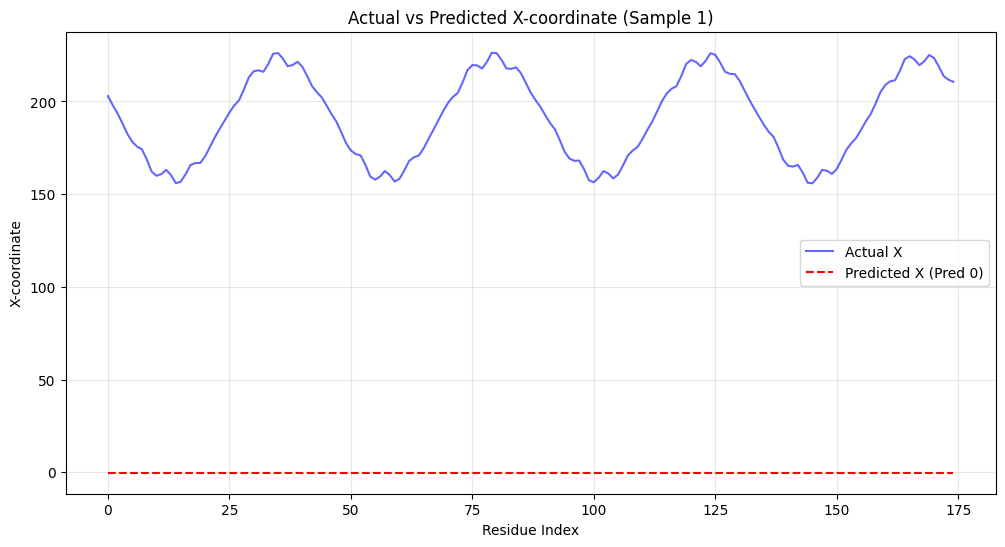

In [11]:
model.eval()
val_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for seq, target, mask in val_loader:
        seq, target, mask = seq.to(device), target.to(device), mask.to(device)
        preds = model(seq)
        loss = criterion(preds, target, mask)
        val_loss += loss.item()
        
        # For visualization, just take the first prediction (k=0)
        all_preds.append(preds[:, 0, :, :].cpu().numpy())
        all_targets.append(target.cpu().numpy())

print(f"Validation RMSD: {val_loss/len(val_loader):.4f}")

# Visualization (Sample 1)
plt.figure(figsize=(12, 6))
# Remove padding via mask
t_sample = all_targets[0][0]
p_sample = all_preds[0][0]

mask_viz = np.abs(t_sample).sum(axis=1) > 0
t_sample = t_sample[mask_viz]
p_sample = p_sample[mask_viz[:len(p_sample)]]

plt.plot(t_sample[:, 0], label='Actual X', color='blue', alpha=0.6)
plt.plot(p_sample[:, 0], label='Predicted X (Pred 0)', color='red', linestyle='--')
plt.title('Actual vs Predicted X-coordinate (Sample 1)')
plt.xlabel('Residue Index')
plt.ylabel('X-coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [12]:
# val_loader에서 첫 배치 하나 꺼내서 정확히 비교 시각화
seq_batch, target_batch = next(iter(val_loader))
seq_batch = seq_batch.to(device)
target_batch = target_batch.to(device)

model.eval()
with torch.no_grad():
    pred_batch = model(seq_batch)

# 첫 샘플의 실제 길이 (PAD=0 기준)
seq0 = seq_batch[0].detach().cpu().numpy()
L = int((seq0 != 0).sum())  # 실제 residue 길이

t0 = target_batch[0].detach().cpu().numpy()[:L]  # (L,3)
p0 = pred_batch[0].detach().cpu().numpy()[:L]    # (L,3)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(t0[:, 0], label="Actual X", alpha=0.7)
plt.plot(p0[:, 0], label="Pred X", linestyle="--", alpha=0.9)
plt.title(f"Actual vs Predicted X (Sample 1, L={L})")
plt.xlabel("Residue Index")
plt.ylabel("X-coordinate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


ValueError: too many values to unpack (expected 2)

In [ ]:
plt.figure(figsize=(12,6))
for k, name in enumerate(["X","Y","Z"]):
    plt.plot(t0[:,k], label=f"Actual {name}", alpha=0.5)
    plt.plot(p0[:,k], label=f"Pred {name}", linestyle="--", alpha=0.8)
plt.title(f"Actual vs Predicted XYZ (L={L})")
plt.legend(ncol=3)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(t0[:,0], t0[:,1], t0[:,2], label="Actual", alpha=0.7)
ax.plot(p0[:,0], p0[:,1], p0[:,2], label="Pred", alpha=0.7, linestyle="--")
ax.set_title(f"3D Trace (L={L})")
ax.legend()
plt.show()
